In [1]:
%load_ext memory_profiler
# %matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib
import os
from fits_reader import shelf,fits_reader
import importlib
import glob
import spec_reader


importlib.reload(fits_reader)
importlib.reload(spec_reader)
importlib.reload(spec_reader.irradiance)
importlib.reload(spec_reader.angle_function)
importlib.reload(shelf)

import gc
import math
import sys
import numpy as np


In [2]:

home_directory = os.environ['HOME']
datadirectory = home_directory + '/spectrometer/wsmr_measurement/20210528_WSMR1/'
d = "0mm"
measuredFiles = glob.glob(datadirectory + d +"*")
bgFiles = glob.glob(datadirectory +"BG_"+ d+"*")
# print(spec_reader.__path__)
matsumi_baffle = spec_reader.angle_function.BaffleClass('sp1_40deg_kiwami.csv','sp1_base_20210401.csv')
ls_irradiance_class= spec_reader.irradiance.IrradianceClass(measuredFiles,bgFiles,matsumi_baffle)
arms = ["armS","armM","armL"]
home_directory = os.environ['HOME']
season_name = "/WSMR2021May/reduction/2021-06-23"
experiment_name = "/abs_calib/vis/"
experiment_directory = home_directory + season_name + experiment_name
eps_shelf = shelf.make_reduction_shelf(experiment_directory)


<!-- <img src="./img/10_CF/CIBER2_config.png" width="500"> -->
# measure LS abs irradiance
<img src="./img/10_CF/abs_measurement.png" width="500">

and reduce ND filter 

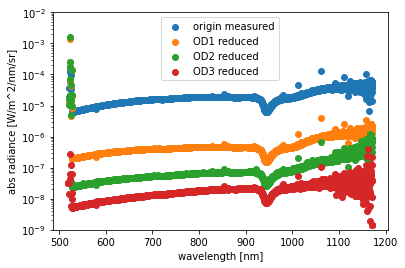

In [3]:
ODs = ["OD1","OD2","OD3"]
cf_classes = {}
arm_name = "armS"
fig,ax = plt.subplots()
for OD in ODs:
    cf_classes[OD] = spec_reader.irradiance.CF_Class(eps_shelf,ls_irradiance_class,OD,arm_name)
    
cf_class = cf_classes["OD1"]
ax.scatter(cf_class.waves_spec,cf_class.ls_irradiance,label= "origin measured")
for OD in ODs:
    cf_class = cf_classes[OD]
    ax.scatter(cf_class.waves_spec,cf_class.ls_irradiance_reduced_by_ND/3.14,label= OD+" reduced")
ax.legend()
ax.set_xlabel("wavelength [nm]")
ax.set_ylabel("abs radiance [W/m^2/nm/sr]")
# ax.set_ylabel("abs irradiance [W/m^2/nm]")
ax.set_ylim(1*10**-9,0.01)
ax.set_yscale("log")


# compare ND filter measurement
① CIBER2<img src="./img/10_CF/CIBER2_config.png" width="500">
② spectrometer<img src="./img/10_CF/spec_config.png" width="250">

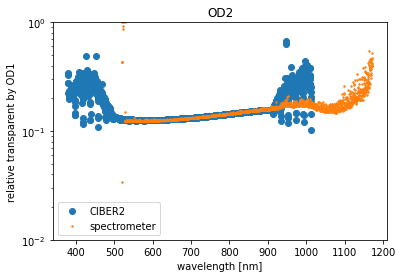

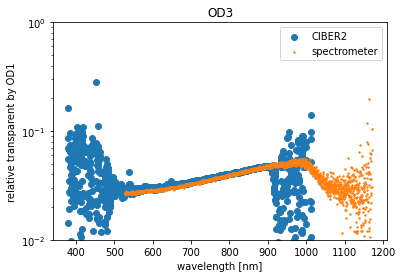

In [4]:
cf_class_base = cf_classes["OD1"]
# print(cf_class.eps_lvf)
for OD in ODs[1:]:
    fig,ax = plt.subplots()
    cf_class = cf_classes[OD]
    transparent = cf_class.eps_lvf/cf_class_base.eps_lvf
    ax.scatter(cf_class.waves_lvf,transparent,label="CIBER2")
    
    transparent_fiber = cf_class.get_ND()[1]/cf_class_base.get_ND()[1]
    ax.scatter(cf_class.waves_spec,transparent_fiber,label="spectrometer", s=2)
    ax.legend()
    ax.set_xlabel("wavelength [nm]")
    ax.set_ylabel("relative transparent by OD1")
    ax.set_ylim(1*10**-2,1)
    ax.set_title(OD)
    ax.set_yscale("log")

(500.0, 950.0)

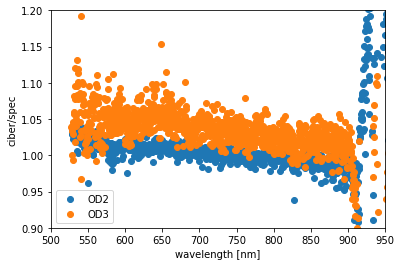

In [5]:
from scipy import interpolate

cf_class_base = cf_classes["OD1"]
fig,ax = plt.subplots()
x =cf_class.waves_spec

for OD in ODs[1:]:
    cf_class = cf_classes[OD]
    transparent_ciber = cf_class.eps_lvf/cf_class_base.eps_lvf
    transparent_ciber_ip_to_spec = interpolate.interp1d(cf_class.waves_lvf,transparent_ciber,fill_value="extrapolate")(x)

    transparent_fiber = cf_class.get_ND()[1]/cf_class_base.get_ND()[1]
    ax.scatter(x,transparent_ciber_ip_to_spec/transparent_fiber,label=OD)
ax.legend()
ax.set_xlabel("wavelength [nm]")
ax.set_ylabel("ciber/spec")
ax.set_ylim(0.9,1.2)
ax.set_xlim(500,950)


Text(0, 0.5, 'Radiance [W/m^2/sr/nm]')

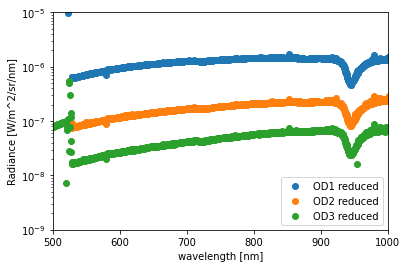

In [6]:
fig,ax = plt.subplots()
for OD in ODs:
    cf_class = cf_classes[OD]
    ax.scatter(cf_class.waves_lvf,cf_class.ls_irradiance_reduced_by_ND_ip_to_lvf,label= OD+" reduced")

ax.legend()
ax.set_xlim(500,1000)
ax.set_ylim(10**-9,10**-5)
ax.set_yscale("log")
ax.set_xlabel("wavelength [nm]")
ax.set_ylabel("Radiance [W/m^2/sr/nm]")

In [7]:
#WPF_transmittance
wpf = sorted(glob.glob(home_directory + '/spectrometer/filter_lib/WPF/pickup/*.csv'))

#blocker_transmittance
blocker = sorted(glob.glob(home_directory + '/spectrometer/filter_lib/blocker/pickup/*.csv'))

#beam_splitter
bs = sorted(glob.glob(home_directory + '/spectrometer/filter_lib/BS/pickup/*.csv'))

In [8]:
import csv
wpf_trans  = []
wavelength_all = []
for i in range(len(wpf)):
    wavelength = []
    trans = []
    with open(wpf[i]) as f:
        rows = csv.reader(f)
        header = next(rows)
        for row in rows:
            wavelength.append(float(row[0]))
            trans.append(float(row[1])/100)
    wpf_trans.append(np.array(trans))
    wavelength_all.append(wavelength)

blocker_trans  = []
for i in range(len(blocker)):
    trans = []
    with open(blocker[i]) as f:
        rows = csv.reader(f)
        header = next(rows)
        for row in rows:
            trans.append(float(row[1])/100)
    blocker_trans.append(np.array(trans))

bs_trans  = []
for i in range(len(bs)):
    trans = []
    with open(bs[i]) as f:
        rows = csv.reader(f)
        header = next(rows)
        for row in rows:
            trans.append(float(row[1])/100)
    bs_trans.append(np.array(trans))

In [9]:
arms1 = wpf_trans[0] * blocker_trans[0] * bs_trans[0] * bs_trans[2]*0.95*0.95*((0.99)**14)
arms2 = wpf_trans[1] * blocker_trans[0] * bs_trans[0] * bs_trans[2]*0.95*0.95*((0.99)**14)

In [10]:
arms_wavelength = wavelength_all[0]

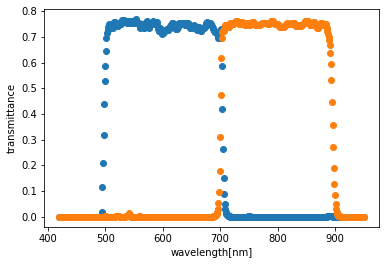

In [11]:
plt.plot(arms_wavelength, arms1, marker='o', lw=0)
plt.plot(arms_wavelength, arms2, marker='o', lw=0)
plt.xlabel('wavelength[nm]')
plt.ylabel('transmittance')
plt.show()

In [12]:
#wavelength_center
lower1 = 0
for i in range(len(arms_wavelength)):
    lower_k = arms1[i]
    lower1 = lower1 + lower_k
lower2 = 0
for i in range(len(arms_wavelength)):
    lower_k = arms2[i]
    lower2 = lower2 + lower_k
upper1 = 0
for i in range(len(arms_wavelength)):
    upper_k = (arms_wavelength[i] * 10**(-9) * arms1[i])
    upper1 = upper1 + upper_k
upper2 = 0
for i in range(len(arms_wavelength)):
    upper_k = (arms_wavelength[i] * 10**(-9) * arms2[i])
    upper2 = upper2 + upper_k

In [13]:
lambda_c1 = upper1 / lower1
lambda_c2 = upper2 / lower2
print(lambda_c1*10**9, lambda_c2*10**9)

600.7870565169055 797.7592330516177


In [14]:
cf_class = cf_classes["OD1"]

In [15]:
I_ref = []
for wave in arms_wavelength[0:110]:
    I_ref.append((3.92825629929246 * (10**-9) * wave) + (-1.45711152283426 * (10 ** -6)))

In [16]:
for i in range(len(arms_wavelength[110:])):
    for j in range(len(cf_class.waves_lvf)):
        if arms_wavelength[110:][i] > cf_class.waves_lvf[j]:
            pass
        else:
            break
    slope = (cf_class.ls_irradiance_reduced_by_ND_ip_to_lvf[j]-cf_class.ls_irradiance_reduced_by_ND_ip_to_lvf[j-1])/(cf_class.waves_lvf[j]-cf_class.waves_lvf[j-1])
    intercept = cf_class.ls_irradiance_reduced_by_ND_ip_to_lvf[j] - (slope*cf_class.waves_lvf[j])
    y_ref = (slope*arms_wavelength[110:][i])+intercept
    I_ref.append(y_ref)

In [17]:
up1 = 0
for i in range(len(arms_wavelength)):
    upper_k = (I_ref[i] * arms1[i] * arms_wavelength[i] * 10**(-9))
    up1 = up1 + upper_k
up2 = 0
for i in range(len(arms_wavelength)):
    upper_k = (I_ref[i] * arms2[i] * arms_wavelength[i] * 10**(-9))
    up2 = up2 + upper_k

In [18]:
area_t = 5.43 * 10 **-2
pixel_t = 3.76 * 10**-10
det_t = 0.8
topt_t = 0.9*0.9*(0.98**12)*0.9
h_t = 6.6 * 10**-34
c_t = 3 * 10**8

In [19]:
cf1 = up1 * h_t * c_t / (area_t * pixel_t * det_t * lambda_c1 * up1 * lower1)
cf2 = up2 * h_t * c_t / (area_t * pixel_t * det_t * lambda_c2 * up2 * lower2)

In [20]:
cf1, cf2

(1.3121107691562786e-10, 1.036567737884075e-10)

In [21]:
wave_wpf_calc = [lambda_c1*10**9, lambda_c2*10**9]
cf_wpf_calc = [cf1, cf2]

In [22]:
cf_class = cf_classes["OD2"]

In [23]:
I_ref_OD2 = []
for wave in arms_wavelength[0:110]:
    I_ref_OD2.append((6.09692309361053 * (10**-10) * wave) + (-2.45786913946768 * (10 ** -7)))

In [24]:
for i in range(len(arms_wavelength[110:])):
    for j in range(len(cf_class.waves_lvf)):
        if arms_wavelength[110:][i] > cf_class.waves_lvf[j]:
            pass
        else:
            break
    slope = (cf_class.ls_irradiance_reduced_by_ND_ip_to_lvf[j]-cf_class.ls_irradiance_reduced_by_ND_ip_to_lvf[j-1])/(cf_class.waves_lvf[j]-cf_class.waves_lvf[j-1])
    intercept = cf_class.ls_irradiance_reduced_by_ND_ip_to_lvf[j] - (slope*cf_class.waves_lvf[j])
    y_ref = (slope*arms_wavelength[110:][i])+intercept
    I_ref_OD2.append(y_ref)

In [25]:
up1_OD2 = 0
for i in range(len(arms_wavelength)):
    upper_k = (I_ref_OD2[i] * arms1[i] * arms_wavelength[i] * 10**(-9))
    up1_OD2 = up1_OD2 + upper_k
up2_OD2 = 0
for i in range(len(arms_wavelength)):
    upper_k = (I_ref_OD2[i] * arms2[i] * arms_wavelength[i] * 10**(-9))
    up2_OD2 = up2_OD2 + upper_k

In [26]:
signal = [355.50677, 856.7188]

In [27]:
cf1_m = up1_OD2 / (signal[0] * lambda_c1 * lower1)
cf2_m = up2_OD2 / (signal[1] * lambda_c2 * lower2)

In [28]:
cf1_m, cf2_m

(3.3556970217447e-10, 2.3772429206896676e-10)

In [29]:
cf_wpf_measure = [cf1_m, cf2_m]

In [30]:
arms_lvf = blocker_trans[0] * bs_trans[0] * bs_trans[2]*0.95*0.95*((0.99)**14) * 0.99

In [31]:
cf_s_lvf = []
for i in range(len(arms_wavelength)):
    if arms_lvf[i]==0:
        cf_s_lvf.append(0)
    else:
        cf_s_lvf.append((25 * h_t * c_t) / (area_t * pixel_t * det_t * arms_lvf[i] * (arms_wavelength[i]**2) * 10**(-9)))

(2048, 4)


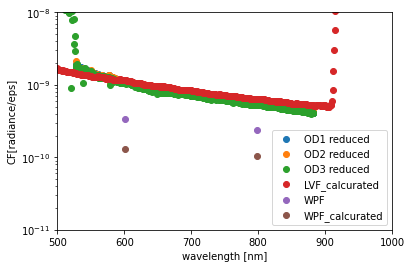

In [36]:
fig,ax = plt.subplots()
# # LVF_measurement

y_list = []
y_sterr_list = []
for OD in ODs:
    cf_class = cf_classes[OD]
    cf = cf_class.cf * 1/0.75
    ax.scatter(cf_class.waves_lvf,cf,label= OD+" reduced")
    y_list.append(cf)
    y_sterr_list.append(cf_class.sterr)
x = cf_class.waves_lvf

# # LVF_calcurated
# w,cf= spec_reader.irradiance.get_cf_from_theory()
ax.scatter(arms_wavelength,cf_s_lvf,label= "LVF_calcurated")

# # WPF_measurement
ax.scatter(wave_wpf_calc,cf_wpf_measure,label= "WPF")

# # WPF_calcurated
ax.scatter(wave_wpf_calc,cf_wpf_calc,label= "WPF_calcurated")

ax.legend()
ax.set_xlim(500,1000)
ax.set_ylim(10**-11,10**-8)
ax.set_yscale("log")
ax.set_xlabel("wavelength [nm]")
ax.set_ylabel("CF[radiance/eps]")


header_latter = [moji + "-sterr" for moji in ODs ]
header = ["wavelength" ]+ ODs + header_latter
file = "./csv/CF_at_LVF_arm_S.csv"

print(np.shape(np.array([x]+y_sterr_list).T))
with open(file,'w',newline='')  as f :
    csv_writer = csv.writer(f) #ファイルオブジェクトをcsv.writerオブジェクトに変換
    csv_writer.writerow(header) #行一括追加
    csv_writer.writerows(np.array([x]+y_list+y_sterr_list).T) #行一括追加    

In [33]:

# for OD in ODs:
#     cf_class = cf_classes[OD]
#     print(cf_class.cf[1000]/cf_class.sterr[1000])
#     print()
#     ax.scatter(cf_class.waves_lvf,cf_class.cf,label= OD+" reduced")
#     y_list.append(cf_class.cf)

In [34]:
cf_set = []
for OD in ODs:
    cf_class = cf_classes[OD]
    cf_set.append(cf_class.cf)

cf_set_np = np.array(cf_set)
cf_average = np.average(cf_set_np,axis = 0)

Text(0, 0.5, 'CF/CF average')

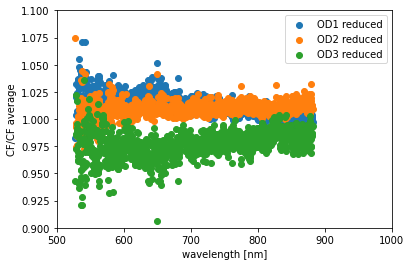

In [35]:
fig,ax = plt.subplots()
for OD in ODs:
    cf_class = cf_classes[OD]
    ax.scatter(cf_class.waves_lvf,cf_class.cf/cf_average,label= OD+" reduced")

ax.legend()
ax.set_xlim(500,1000)
ax.set_ylim(0.9,1.1)
# ax.set_yscale("log")
ax.set_xlabel("wavelength [nm]")
ax.set_ylabel("CF/CF average")